In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata
import datetime
import numpy as np
import matplotlib.dates as mdates
import data_processing as dp

In [4]:
"""
plot
Plots data with 7 day average

data: dataframe time series with column 'date' and data in 1st column
plot_color: Color to use for plot
label: string of plot label
rolling: Boolean, True to overlay 7-day average
"""
def plot(data, ax=None, plot_color="blue", label="", rolling=True, font={ 'size':13, 'weight':'light'}):
    ax = ax or plt.gca()
    x, y0 = data.date, data.iloc[:,1]
    if(rolling):
        y1 = data.iloc[:,1].rolling(7).mean()
        ax.plot(x, y0, alpha=.3, color=plot_color)
        ax.plot(x, y1, color=plot_color)
        ax.fill_between(x, y1, 0, facecolor=plot_color, color=plot_color, alpha=0.2)
    else:
        ax.plot(x, y0, color=plot_color)
        ax.fill_between(x, y0, 0, facecolor=plot_color, color=plot_color, alpha=0.2)
    ax.set_title(label, fontdict={'size': 20})
    subtext = []
    for i in [-1,-2,-7]:
        last_update_day = x.iloc[i].strftime('%b-%d')
        last_val = round(y0.iloc[i], 1)
        last_val_formatted = '{:,}'.format(last_val)
        subtext.append(f" {last_update_day}: {last_val_formatted}")

    ax.text(.5, 0.97, subtext[0], ha='center', transform=ax.transAxes, fontdict=font)
    ax.text(.5, 0.94, subtext[1], ha='center',transform=ax.transAxes, fontdict=font)
    ax.text(.5, 0.91, subtext[2], ha='center',transform=ax.transAxes, fontdict=font)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
    ax.grid(alpha=.4)
    ax.set_ylim(0)
    return ax




In [5]:
def plot_four(region="USA", start_date=pd.Timestamp(2020,1,1), end_date=pd.Timestamp.today()):
    if region == "USA":
        pos = dp.get_us_positivity(start_date, end_date)
        case = dp.get_us_cases(start_date, end_date)
        death = dp.get_us_deaths(start_date, end_date)
        hosp = dp.get_us_hospitalizations(start_date, end_date)
    else:
        pos = dp.get_state_positivity(dp.regions[region], start_date, end_date)
        case = dp.get_state_cases(dp.regions[region], start_date, end_date)
        death = dp.get_state_deaths(dp.regions[region], start_date, end_date)
        hosp = dp.get_state_hospitalizations(dp.regions[region], start_date, end_date)


    fig, axs = plt.subplots(1,4, dpi=100, figsize=(25,10))
    plot(pos, axs[0], plot_color="purple", label=f"Test Positivity")
    plot(case, axs[1], plot_color="red", label=f"Cases")
    plot(hosp, axs[2], plot_color="blue", label=f"In Hospital")
    plot(death, axs[3], plot_color="black", label=f"Deaths")
    fig.autofmt_xdate()
    fig.suptitle(f"{region} COVID Data {datetime.date.today().strftime('%m/%d/%y')}", fontweight="bold", fontsize=24)
    plt.show()

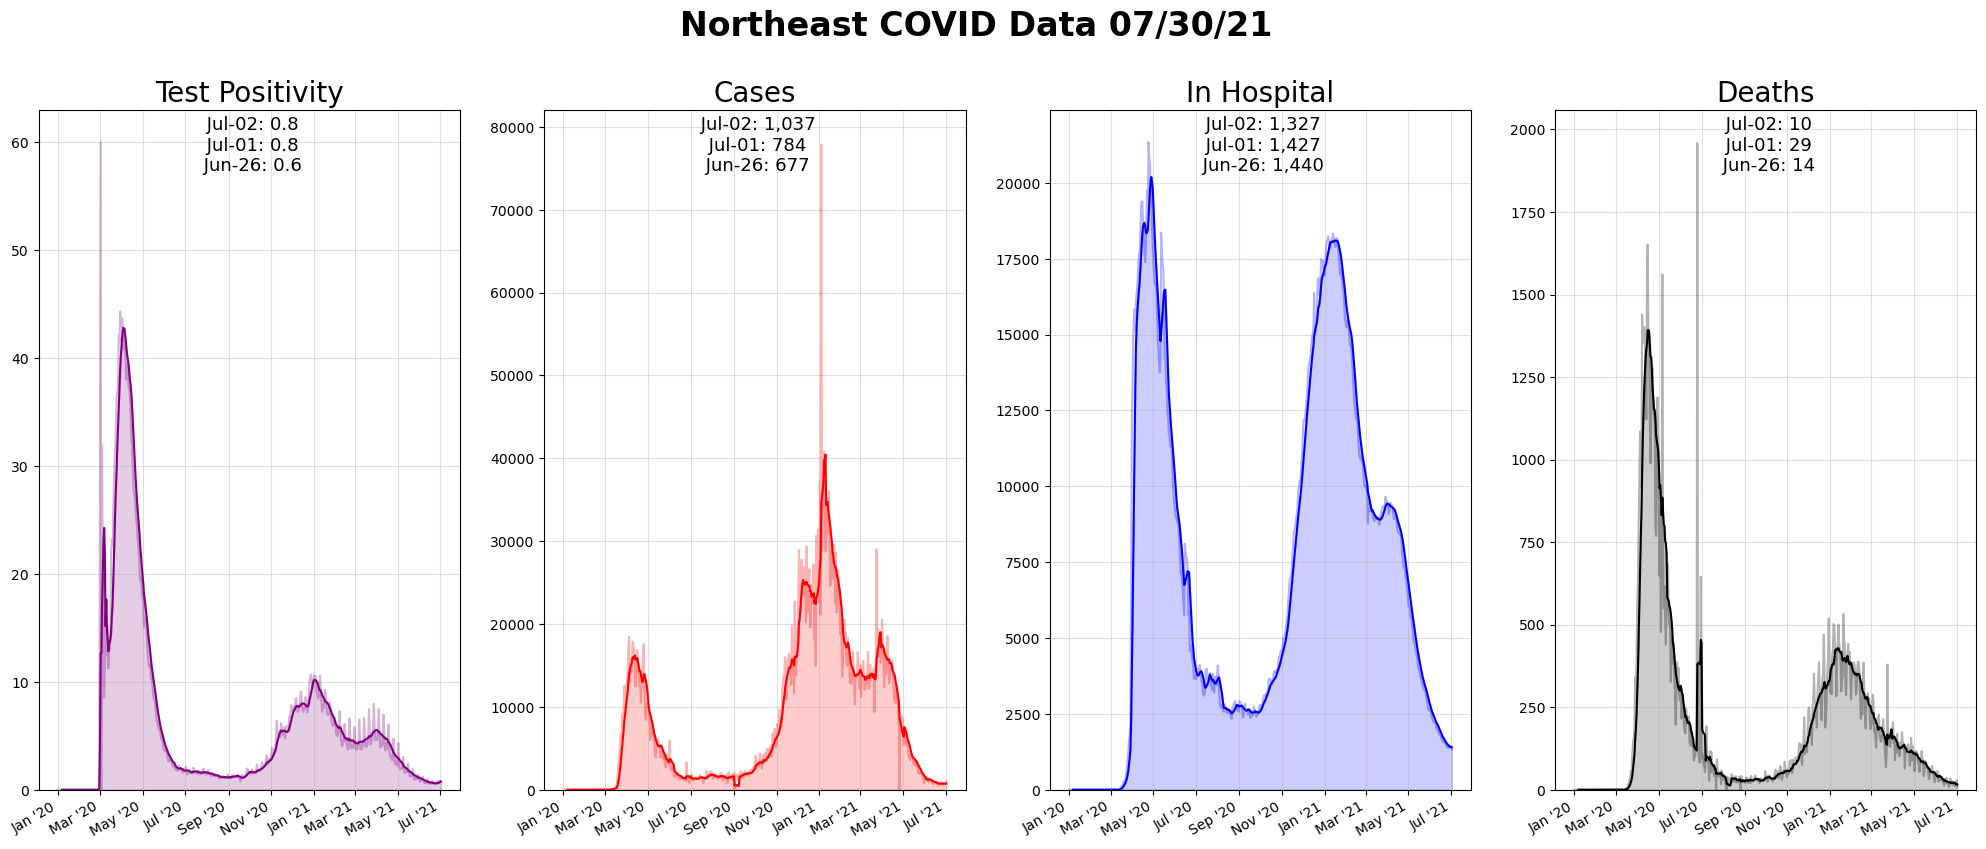

In [6]:
plot_four(region="Northeast", end_date=pd.Timestamp(2021,7,2))

In [31]:
def plot_table(data, ax=None, plot_color="blue", label="", rolling=True):
    ax.axis('off')
    ax.axis('tight')
    ax.set_title(label, pad=0, y=.9, fontdict={'fontsize': 10})
    #create table
    table = ax.table(cellText=data.values, colLabels=data.columns, cellLoc='center', loc='center', cellColours=[[plot_color + (.1,)]*3]*6, colColours=[plot_color + (.5,)]*3)

def get_table(data, name="cases"):
    data.iloc[:,1] = data.iloc[:,1].rolling(7).mean()
    maxDate = data['date'].max()
    recentNum = data[data.date == maxDate].iloc[:,1].item()
    if "Test Positivity" in name:
        recentNumFormat = round(recentNum,1)
    else:
        recentNumFormat = '{:,}'.format(round(recentNum))
    lst = []
    newRow = {'Date': maxDate.strftime("%m/%d/%y"), name: recentNumFormat, 'Change': '-'}
    lst.append(newRow)
    for label, daysBack in [("1 wk ago", -7), ("2 wks ago", -14), ("1 mo ago", -30), ("2 mo ago", -60), ("1 yr ago", -365)]:
        newDate = (maxDate + datetime.timedelta(daysBack))
        newNum = data[data.date == newDate].iloc[:,1]
        if(newNum.size == 1):
            newNum = newNum.item()
        else:
            newNum = math.nan
        if not math.isnan(newNum):
            if "Test Positivity" in name:
                numFormat = round(newNum,1)
            else:
                numFormat = '{:,}'.format(round(newNum))
            change = round(-1 * (1 - (recentNum / newNum)) * 100, 1)
        else:
            numFormat = "N/A"
            change = "N/A"

        newRow = {'Date': label, name: numFormat, 'Change': f"{change}%"}
        lst.append(newRow)
    return pd.DataFrame(lst)

def plot_tables(region="USA", start_date=pd.Timestamp(2020,1,1), end_date=pd.Timestamp.today()):
    if region == "USA":
        pos = get_table(dp.get_us_positivity(start_date, end_date), name="Test Positivity")
        case = get_table(dp.get_us_cases(start_date, end_date), name="Cases")
        death = get_table(dp.get_us_deaths(start_date, end_date), name="Deaths")
        hosp = get_table(dp.get_us_hospitalizations(start_date, end_date), name="In Hospital")
    else:
        pos = get_table(dp.get_state_positivity(dp.regions[region], start_date, end_date), name="Test Positivity")
        case = get_table(dp.get_state_cases(dp.regions[region], start_date, end_date), name="Cases")
        death = get_table(dp.get_state_deaths(dp.regions[region], start_date, end_date), name="Deaths")
        hosp = get_table(dp.get_state_hospitalizations(dp.regions[region], start_date, end_date), name="In Hospital")

    fig, axs = plt.subplots(2,2, dpi=250)
    plt.subplots_adjust(wspace=0.1, hspace=0, bottom=0)
    plot_table(case, axs[0][0], plot_color=(.41,.05,.67), label=f"Cases")
    plot_table(death, axs[1][0], plot_color=(1,0,0), label=f"Deaths")
    plot_table(hosp, axs[1][1], plot_color=(0,0,0), label=f"In Hospital")
    plot_table(pos, axs[0][1], plot_color=(0,0,1), label=f"Test Positivity")
    fig.suptitle(f"{region} COVID Data {end_date.strftime('%m/%d/%y')}\n All Numbers are 7-day Rolling Averages", fontweight="bold")
    fig.patch.set_visible(False)
    plt.show()

c:\Users\jonah\OneDrive\Documents\GitHub\covid-twitter-bot\data_processing.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  test_positivity = pos_sum / (pos_sum + neg_sum) * 100


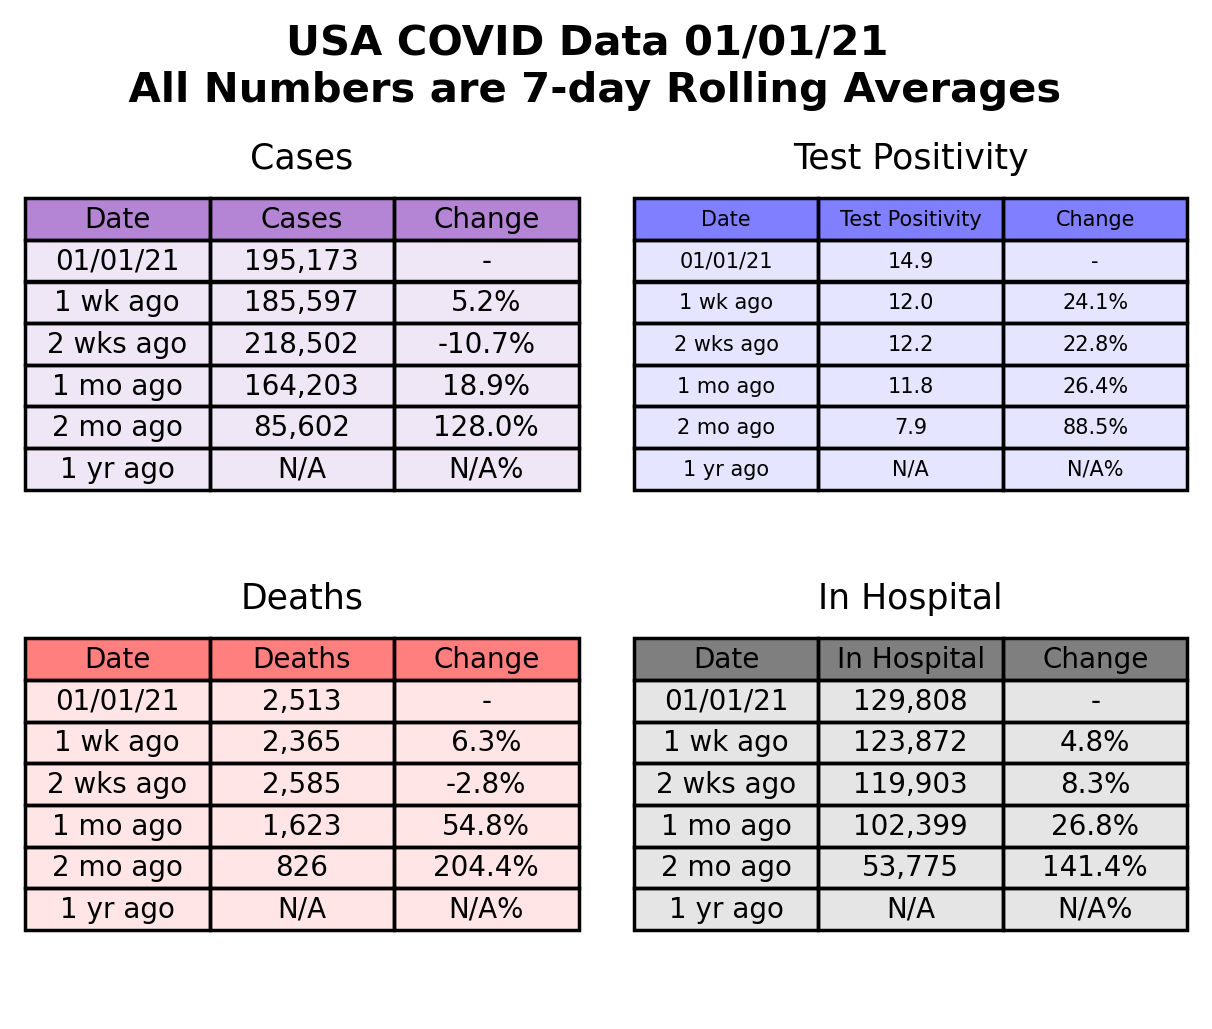

In [32]:
plot_tables(end_date=pd.Timestamp(2021,1,1))

In [11]:
import math